# HEAPML Project
## Gradient Boosted Decision Tree

In [34]:
### GENERAL IMPORTS ###
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from itertools import cycle, combinations

### PYMATGEN/MATMINER IMPORTS ###
from matminer.featurizers import composition as cf
from matminer.featurizers.base import MultipleFeaturizer

### SKLEARN IMPORTS ###
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV, RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, label_binarize

### SKOMPTOMIZE IMPORTS ###
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

### 1. Import Featurized Data

In [3]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset('magpie')])
feature_labels = feature_calculators.feature_labels()

alloys = pd.read_csv('./data/featurized_alloys.csv')

display(alloys)

,formula,phase,composition_obj,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,AgAlCoCrCuNi,3,Ag1 Al1 Co1 Cr1 Cu1 Ni1,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,...,1.548471,0.357311,0.476415,0.0,194.0,229.0,35.0,220.500000,8.833333,194.0
1,AgCoCrFeMnNi,1,Ag1 Co1 Cr1 Fe1 Mn1 Ni1,6,0.408248,0.302853,0.238495,0.215285,0.199372,24.0,...,2.110663,0.709140,0.746951,0.0,194.0,229.0,35.0,219.833333,9.555556,194.0
2,Al0.02CoCrFeMnNi,1,Al0.02 Co1 Cr1 Fe1 Mn1 Ni1,6,0.445450,0.340633,0.274847,0.250697,0.233988,13.0,...,2.110663,0.847577,0.782462,0.0,194.0,229.0,35.0,218.824701,10.617292,194.0
3,Al0.03CoCrFeMnNi,1,Al0.03 Co1 Cr1 Fe1 Mn1 Ni1,6,0.444586,0.339956,0.274300,0.250199,0.233523,13.0,...,2.110663,0.845892,0.782246,0.0,194.0,229.0,35.0,218.836978,10.605947,194.0
4,Al0.04CoCrFeMnNi,1,Al0.04 Co1 Cr1 Fe1 Mn1 Ni1,6,0.443735,0.339282,0.273756,0.249702,0.233059,13.0,...,2.110663,0.844214,0.782026,0.0,194.0,229.0,35.0,218.849206,10.594608,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,Zr2.0TiHfVNb2.0,1,Zr2 Ti1 Hf1 V1 Nb2,5,0.473804,0.381200,0.331220,0.315980,0.306266,22.0,...,0.000023,0.000003,0.000006,0.0,194.0,229.0,35.0,209.000000,17.142857,194.0
1069,ZrTiHfCuNiFe,1,Zr1 Ti1 Hf1 Cu1 Ni1 Fe1,6,0.408248,0.302853,0.238495,0.215285,0.199372,22.0,...,2.110663,0.451013,0.601344,0.0,194.0,229.0,35.0,210.166667,16.166667,194.0
1070,ZrTiHfNb0.5Mo0.5,1,Zr1 Ti1 Hf1 Nb0.5 Mo0.5,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0
1071,ZrTiHfNb0.5Ta0.5,1,Zr1 Ti1 Hf1 Nb0.5 Ta0.5,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0


### 2. Generate Dataset
*Note: the formula, phase and composition_obj columns are removed from $X$*

In [4]:
x_cols = [c for c in alloys.columns if c not in ['formula', 'phase', 'composition_obj']]

y = alloys['phase'].values
X = alloys[x_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

display(X)

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,6,0.408248,0.302853,0.238495,0.215285,0.199372,13.0,47.0,34.0,28.000000,...,1.548471,0.357311,0.476415,0.0,194.0,229.0,35.0,220.500000,8.833333,194.0
1,6,0.408248,0.302853,0.238495,0.215285,0.199372,24.0,47.0,23.0,29.500000,...,2.110663,0.709140,0.746951,0.0,194.0,229.0,35.0,219.833333,9.555556,194.0
2,6,0.445450,0.340633,0.274847,0.250697,0.233988,13.0,28.0,15.0,25.948207,...,2.110663,0.847577,0.782462,0.0,194.0,229.0,35.0,218.824701,10.617292,194.0
3,6,0.444586,0.339956,0.274300,0.250199,0.233523,13.0,28.0,15.0,25.922465,...,2.110663,0.845892,0.782246,0.0,194.0,229.0,35.0,218.836978,10.605947,194.0
4,6,0.443735,0.339282,0.273756,0.249702,0.233059,13.0,28.0,15.0,25.896825,...,2.110663,0.844214,0.782026,0.0,194.0,229.0,35.0,218.849206,10.594608,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,5,0.473804,0.381200,0.331220,0.315980,0.306266,22.0,72.0,50.0,39.857143,...,0.000023,0.000003,0.000006,0.0,194.0,229.0,35.0,209.000000,17.142857,194.0
1069,6,0.408248,0.302853,0.238495,0.215285,0.199372,22.0,72.0,50.0,36.166667,...,2.110663,0.451013,0.601344,0.0,194.0,229.0,35.0,210.166667,16.166667,194.0
1070,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,72.0,50.0,43.875000,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0
1071,5,0.467707,0.370312,0.312720,0.292700,0.279049,22.0,73.0,51.0,47.750000,...,0.000023,0.000006,0.000008,0.0,194.0,229.0,35.0,202.750000,13.125000,194.0


### 3. Train Model
`random_state` parameter is set to 0 in order to ensure reproducibility of results.

In [5]:
gbdt = GradientBoostingClassifier(random_state=0)

gbdt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

### 4. Evaluate Model

In [6]:
y_pred = gbdt.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))

Precision: 0.690148
Recall: 0.690141
F1: 0.690058


### 5. Feature Selection

[(31, 0.6905921196004187), (30, 0.6880254963006075), (23, 0.6853374944075178), (55, 0.6841804336763511), (28, 0.6805796049100254), (29, 0.6804889046698219), (25, 0.6798064368979392), (33, 0.6794784554025377), (43, 0.6794172408277553), (12, 0.6770562761388181)]


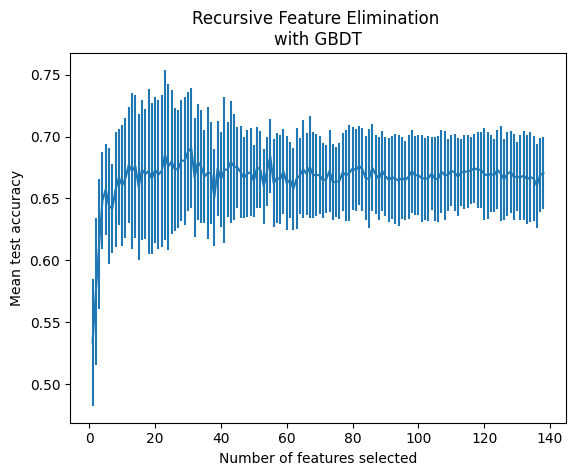

In [7]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
gbdt = GradientBoostingClassifier(random_state=0)

rfecv = RFECV(estimator=gbdt, cv=cv, scoring="f1_weighted", n_jobs=-1)
rfecv.fit(X_train, y_train)

selected_features = rfecv.get_feature_names_out()

print(list(sorted(zip(range(1, 139), rfecv.cv_results_["mean_test_score"]), key=lambda x: x[1], reverse=True))[:10])

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith GBDT")
plt.savefig("graphs/rfecv_gbdt.png")
plt.show()

### 6. Regenerate Dataset

In [8]:
rfe = RFE(estimator=gbdt, n_features_to_select=27, step=1)
rfe.fit(X_train, y_train)

selected_features = rfe.get_feature_names_out()

print(selected_features)

x_cols = [c for c in alloys.columns if c in selected_features]

y = alloys['phase'].values
X = alloys[x_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

display(X)

['2-norm' '10-norm' 'MagpieData avg_dev Number'
 'MagpieData mean AtomicWeight' 'MagpieData avg_dev AtomicWeight'
 'MagpieData range MeltingT' 'MagpieData mean MeltingT'
 'MagpieData avg_dev MeltingT' 'MagpieData avg_dev Column'
 'MagpieData avg_dev CovalentRadius' 'MagpieData mean Electronegativity'
 'MagpieData mean NsValence' 'MagpieData avg_dev NsValence'
 'MagpieData mean NdValence' 'MagpieData avg_dev NdValence'
 'MagpieData mean NValence' 'MagpieData avg_dev NsUnfilled'
 'MagpieData mean NdUnfilled' 'MagpieData avg_dev NdUnfilled'
 'MagpieData avg_dev NUnfilled' 'MagpieData minimum GSvolume_pa'
 'MagpieData range GSvolume_pa' 'MagpieData mean GSvolume_pa'
 'MagpieData avg_dev GSvolume_pa' 'MagpieData mean GSmagmom'
 'MagpieData avg_dev GSmagmom' 'MagpieData mean SpaceGroupNumber']


,2-norm,10-norm,MagpieData avg_dev Number,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,MagpieData range MeltingT,MagpieData mean MeltingT,MagpieData avg_dev MeltingT,MagpieData avg_dev Column,MagpieData avg_dev CovalentRadius,...,MagpieData mean NdUnfilled,MagpieData avg_dev NdUnfilled,MagpieData avg_dev NUnfilled,MagpieData minimum GSvolume_pa,MagpieData range GSvolume_pa,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mean SpaceGroupNumber
0,0.408248,0.199372,6.666667,61.336406,16.247130,1246.53,1533.695000,358.305000,1.666667,7.500000,...,1.666667,1.666667,1.666667,10.245,6.235,12.605833,2.532778,0.357311,0.476415,220.500000
1,0.408248,0.199372,5.833333,64.712323,14.385292,945.07,1706.821667,219.904444,1.500000,6.833333,...,3.166667,1.500000,1.500000,10.245,6.085,11.550431,1.593190,0.709140,0.746951,219.833333
2,0.445450,0.233988,1.257123,55.965213,2.269390,1246.53,1797.742908,157.575372,1.219028,5.630069,...,3.784861,1.053952,1.199981,10.245,6.235,10.617965,0.319247,0.847577,0.782462,218.824701
3,0.444586,0.233523,1.285330,55.907592,2.310700,1246.53,1796.024672,158.628491,1.228415,5.644858,...,3.777336,1.060832,1.199957,10.245,6.235,10.629620,0.332514,0.845892,0.782246,218.836978
4,0.443735,0.233059,1.313303,55.850199,2.351666,1246.53,1794.313254,159.672021,1.237717,5.659486,...,3.769841,1.067649,1.199924,10.245,6.235,10.641227,0.345673,0.844214,0.782026,218.849206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,0.473804,0.306266,9.918367,92.222751,25.038430,809.00,2340.857143,280.979592,0.489796,7.224490,...,7.285714,0.816327,0.489796,13.010,10.185,19.235714,3.109388,0.000003,0.000006,209.000000
1069,0.408248,0.199372,13.222222,82.610900,34.830733,1148.23,1911.961667,279.705000,2.833333,20.333333,...,5.000000,3.000000,2.833333,10.320,12.875,15.700833,4.994167,0.451013,0.601344,210.166667
1070,0.467707,0.279049,14.062500,103.003547,37.743226,955.00,2349.500000,315.000000,0.562500,7.750000,...,7.375000,0.937500,0.562500,15.690,7.505,19.755000,2.942500,0.000006,0.000008,202.750000
1071,0.467707,0.279049,18.437500,113.627032,49.261696,1349.00,2398.750000,364.250000,0.375000,5.937500,...,7.625000,0.562500,0.375000,16.690,6.505,20.058750,2.638750,0.000006,0.000008,202.750000


### 7. Retrain Model

In [9]:
gbdt = GradientBoostingClassifier(random_state=0)

gbdt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

### 8. Re-evaluate Model

In [10]:
y_pred = gbdt.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))

Precision: 0.685135
Recall: 0.695775
F1: 0.684862


### 9. Hyperparameter Tuning

In [ ]:
space = [Real(10**-2, 10**0, 'log-uniform', name='learning_rate'), 
         Integer(1, 10**3, 'log-uniform', name='n_estimators'), 
         Real(10**-2, 10**0, 'log-uniform', name='subsample'),
         Categorical(['sqrt', 'log2', None], name='max_features'),
         Integer(2, 10, 'uniform', name='min_samples_split'), 
         Integer(1, 5, 'uniform', name='min_samples_leaf'), 
         Integer(1, 10, 'uniform', name='max_depth'),]

In [ ]:
@use_named_args(space)
def objective(**params):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    gbdt = GradientBoostingClassifier(random_state=0)
    gbdt.set_params(**params)
    gbdt.fit(X_train, y_train)
    y_pred = gbdt.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    return 1.0 - score

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

[0.04806022659161656, 1000, 0.546041165576287, None, 2, 1, 10]
0.7324823711712554


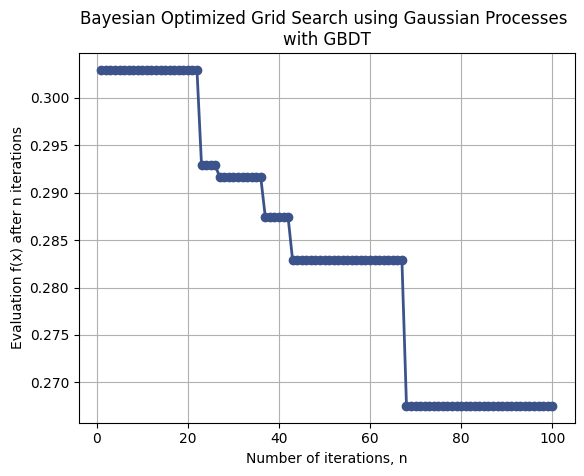

In [ ]:
n_calls = 100
result = gp_minimize(objective,
                     space,
                     n_calls=n_calls,
                     random_state=0)

print(result.x)
print(1-result.fun)
plot_convergence(result)
plt.xlabel("Number of iterations, n")
plt.ylabel("Evaluation f(x) after n iterations")
plt.title("Bayesian Optimized Grid Search using Gaussian Processes \nwith GBDT")
plt.savefig("graphs/gp_gbdt.png")

### 10. Retrain and Evaluate Model

Precision: 0.732260
Recall: 0.735211
F1: 0.732482


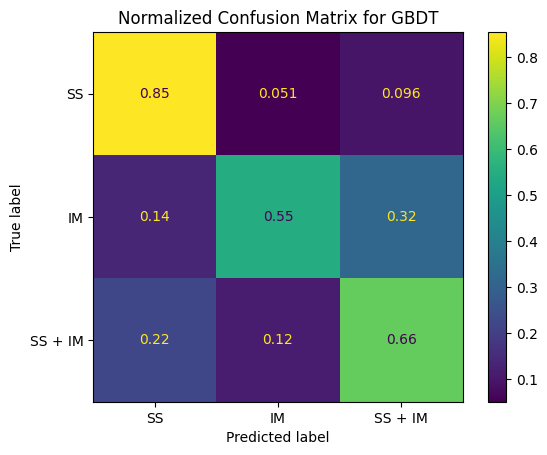

In [17]:
gbdt = GradientBoostingClassifier(learning_rate=0.04806022659161656,
                                  n_estimators=1000,
                                  max_features=None,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_depth=10,
                                  subsample=0.546041165576287,
                                  random_state=0)

gbdt.fit(X_train, y_train)

y_pred = gbdt.predict(X_test)

print('Precision: %.6f' % precision_score(y_test, y_pred, average='weighted'))
print('Recall: %.6f' % recall_score(y_test, y_pred, average='weighted'))
print('F1: %.6f' % f1_score(y_test, y_pred, average='weighted'))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', display_labels=['SS', 'IM', 'SS + IM'])
plt.title("Normalized Confusion Matrix for GBDT")
plt.savefig("graphs/cm_gbdt.png")

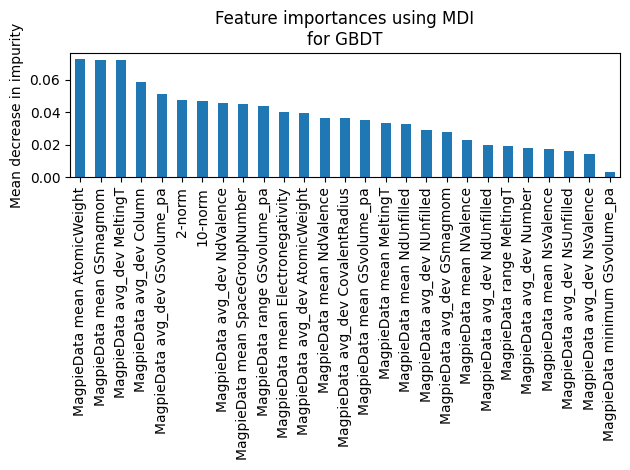

In [40]:
feature_names = [f"{i}" for i in (X.columns)]

importances = gbdt.feature_importances_

forest_importances = pd.Series(importances, index=feature_names).sort_values(axis=0, ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI\nfor GBDT")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("graphs/fi_gbdt.png")

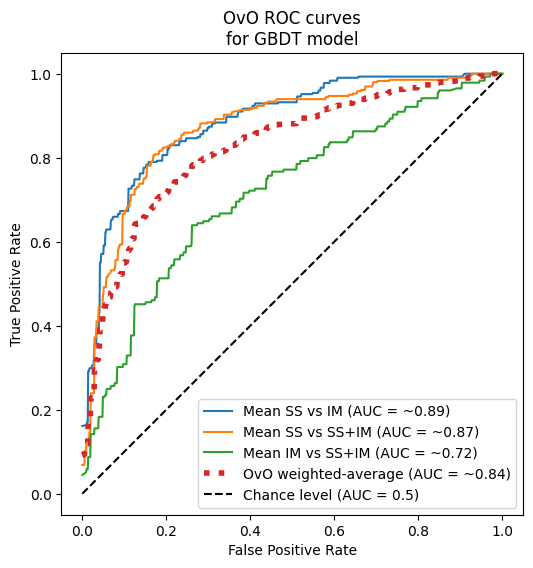

In [39]:
class_labels = ["SS", "IM", "SS+IM"]
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr_grid = np.linspace(0.0, 1.0, 1000)

pair_list = list(combinations(np.unique(y), 2))

pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):

    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="weighted",
)

ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {class_labels[label_a-1]} vs {class_labels[label_b-1]} (AUC = ~{pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"OvO weighted-average (AUC = ~{macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OvO ROC curves\nfor GBDT model")
plt.legend()
plt.savefig("graphs/ovo_roc_gbdt.png")
plt.show()